# Part 2

In [ ]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import random

In [8]:
mnist_train = datasets.MNIST(
    root="./data",
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
mnist_test = datasets.MNIST(
    root="./data",
    train=False,
    transform=transforms.ToTensor(),
    download=True
)
print("MNIST downloaded successfully!")

MNIST downloaded successfully!


## Distribution of Classes

Train size: 60000
Test size: 10000


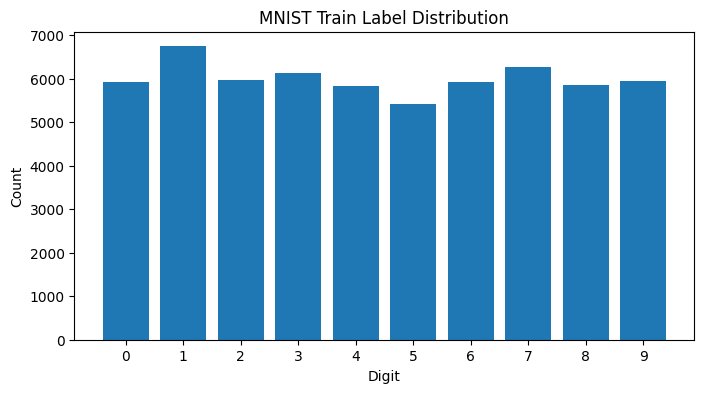

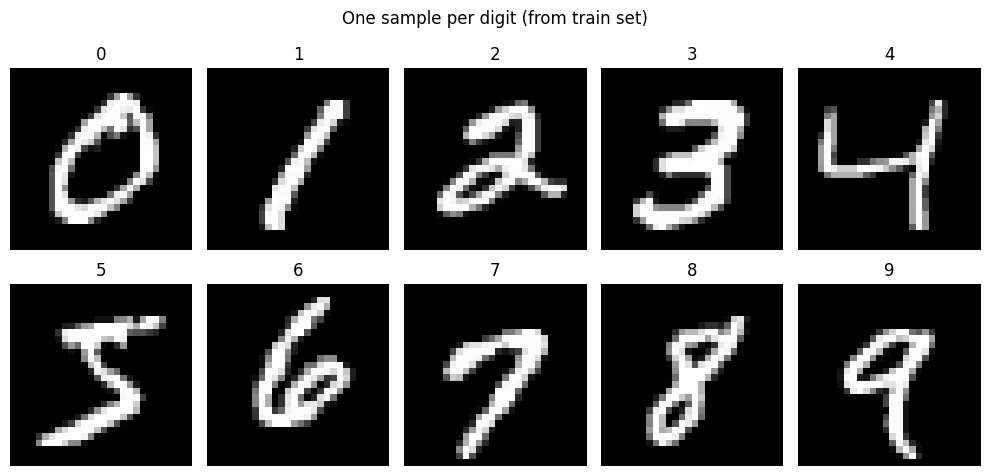

Train mean (single-channel): 0.130660
Train std  (single-channel): 0.308108


In [9]:
train_dataset = mnist_train
test_dataset = mnist_test

print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")
# Class distribution for training dataset
labels = [int(y) for (_, y) in train_dataset]
counts = Counter(labels)
labels_sorted = sorted(counts.items())
xs = [k for k, v in labels_sorted]
ys = [v for k, v in labels_sorted]

plt.figure(figsize=(8,4))
plt.bar(xs, ys, color='tab:blue')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('MNIST Train Label Distribution')
plt.xticks(xs)
plt.show()

# Display a grid of sample image of each class
fig, axes = plt.subplots(2,5, figsize=(10,5))
fig.suptitle('One sample per digit (from train set)')
seen = set()
for img, label in train_dataset:
    lbl = int(label)
    if lbl in seen:
        continue
    seen.add(lbl)
    r = lbl // 5
    c = lbl % 5
    ax = axes[r,c]
    # img is a tensor CxHxW, convert to HxW
    im = img.squeeze().numpy()
    ax.imshow(im, cmap='gray')
    ax.set_title(str(lbl))
    ax.axis('off')
    if len(seen) == 10:
        break
plt.tight_layout()
plt.show()

stack_sum = 0.0
stack_sq_sum = 0.0
n_pixels = 0
for img, _ in train_dataset:
    arr = img.numpy()  # 1 x H x W
    stack_sum += arr.sum()
    stack_sq_sum += (arr ** 2).sum()
    n_pixels += arr.size
mean = stack_sum / n_pixels
std = np.sqrt(stack_sq_sum / n_pixels - mean ** 2)
print(f"Train mean (single-channel): {mean:.6f}")
print(f"Train std  (single-channel): {std:.6f}")

In [10]:
seed = 4786
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

batch_size = 128
transform = transforms.ToTensor()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using device: cpu


## Accuracy on Normal MNIST data

In [11]:
# Define a small Fully-Connected Neural Network (three hidden layers)
class SimpleFCNN(nn.Module):
    def __init__(self, input_dim=28*28, h1=256, h2=128, h3=64, num_classes=10):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, num_classes)
        self.leaky = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x, return_proba=False):
        # x: batch x 1 x 28 x 28
        x = x.view(x.size(0), -1)  # flatten
        a1 = self.leaky(self.fc1(x))
        a2 = self.leaky(self.fc2(a1))
        a3 = self.leaky(self.fc3(a2))
        logits = self.fc4(a3)
        if return_proba:
            return torch.softmax(logits, dim=1)
        return logits

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for imgs, targets in loader:
        imgs = imgs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)         
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    return running_loss / len(loader.dataset)


def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, targets in loader:
            imgs = imgs.to(device)
            targets = targets.to(device)
            outputs = model(imgs) 
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    return correct / total

epochs = 5
model = SimpleFCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

losses_normal = []
losses_scrambled = []

for ep in range(1, epochs+1):
    loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    losses_normal.append(loss)   
    acc = evaluate(model, test_loader, device)
    print(f'[Normal MNIST] Epoch {ep}/{epochs}  Loss: {loss:.4f}  Test Acc: {acc*100:.2f}%')

acc_normal = evaluate(model, test_loader, device)
print('Final test accuracy on Normal MNIST: {:.2f}%'.format(acc_normal*100))

[Normal MNIST] Epoch 1/5  Loss: 0.3733  Test Acc: 94.45%
[Normal MNIST] Epoch 2/5  Loss: 0.1332  Test Acc: 96.54%
[Normal MNIST] Epoch 3/5  Loss: 0.0899  Test Acc: 97.02%
[Normal MNIST] Epoch 4/5  Loss: 0.0636  Test Acc: 97.74%
[Normal MNIST] Epoch 5/5  Loss: 0.0490  Test Acc: 97.34%
Final test accuracy on Normal MNIST: 97.34%


## Weights Visualisation as Heatmaps

/tmp/ipykernel_55/1520996277.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


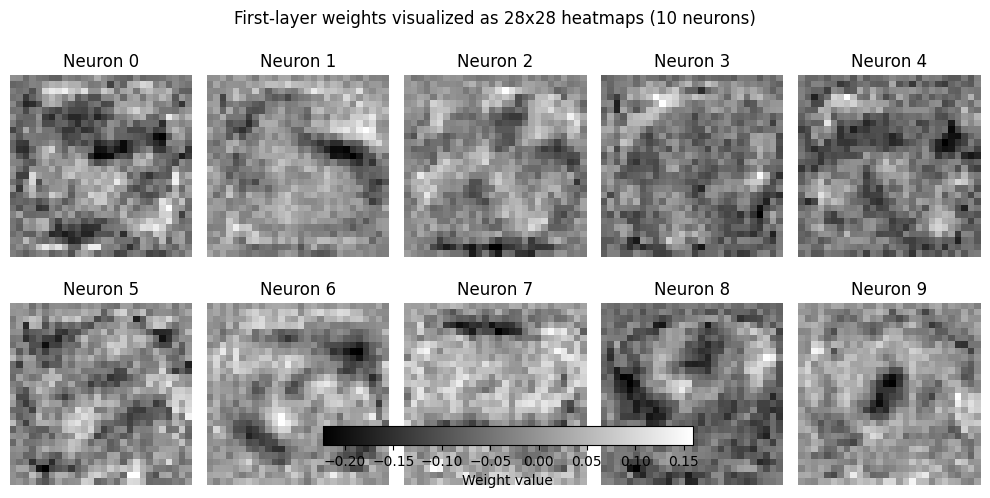

In [12]:
# Took 10 neurons from the first hidden layer and reshape to 28x28
weights = model.fc1.weight.data.cpu().numpy()  # shape: (hidden, 784)

n_show = 10
fig, axes = plt.subplots(2, 5, figsize=(10,5))
fig.suptitle('First-layer weights visualized as 28x28 heatmaps (10 neurons)')
plt.subplots_adjust(top=0.85)
for i in range(n_show):
    w = weights[i].reshape(28,28)
    r = i // 5
    c = i % 5
    ax = axes[r, c]
    im = ax.imshow(w, cmap='gray', interpolation='nearest')
    ax.set_title(f'Neuron {i}')
    ax.axis('off')
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.05, pad=0.05)
cbar.set_label('Weight value')
plt.tight_layout()
plt.show()

## Comparision on Scrambelled Data and Normal Data

[Scrambled MNIST] Epoch 1/5  Loss: 0.3812  Test Acc: 95.08%
[Scrambled MNIST] Epoch 2/5  Loss: 0.1383  Test Acc: 96.43%
[Scrambled MNIST] Epoch 3/5  Loss: 0.0896  Test Acc: 97.09%
[Scrambled MNIST] Epoch 4/5  Loss: 0.0672  Test Acc: 97.11%
[Scrambled MNIST] Epoch 5/5  Loss: 0.0518  Test Acc: 97.38%
Final test accuracy on Scrambled MNIST: 97.38%

Comparison:
Accuracy (Normal):   97.34%
Accuracy (Scrambled):97.38%


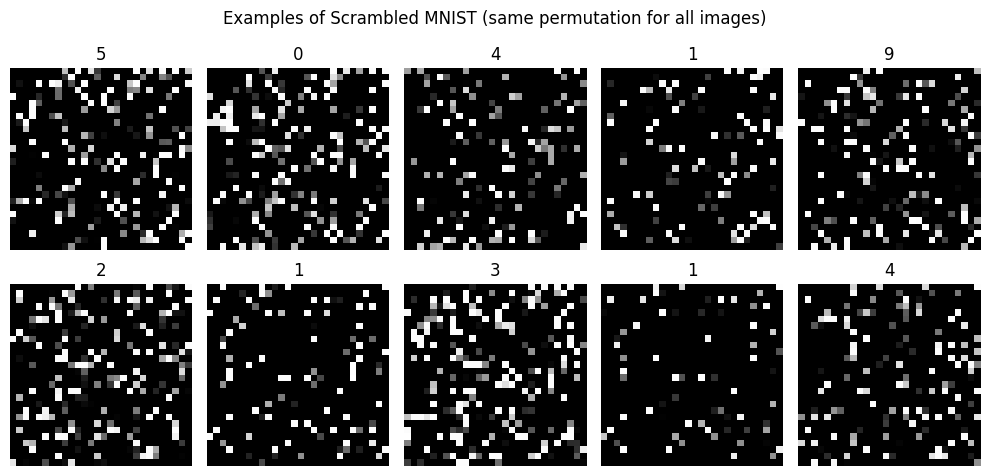

In [13]:
perm = torch.randperm(28*28, generator=torch.manual_seed(seed))

class ScrambledMNIST(Dataset):
    def __init__(self, base_dataset, perm):
        self.base = base_dataset
        self.perm = perm
    def __len__(self):
        return len(self.base)
    def __getitem__(self, idx):
        img, label = self.base[idx]
        flat = img.view(-1)
        scrambled = flat[self.perm]
        scrambled = scrambled.view(1, 28, 28)
        return scrambled, label

# Create scrambled datasets and loaders same permutation for train & test
scr_train = ScrambledMNIST(train_dataset, perm)
scr_test  = ScrambledMNIST(test_dataset, perm)

scr_train_loader = DataLoader(scr_train, batch_size=batch_size, shuffle=True)
scr_test_loader  = DataLoader(scr_test, batch_size=batch_size, shuffle=False)

model_scr = SimpleFCNN().to(device)
optimizer_scr = torch.optim.Adam(model_scr.parameters(), lr=1e-3)

for ep in range(1, epochs+1):
    loss = train_one_epoch(model_scr, scr_train_loader, optimizer_scr, criterion, device)
    losses_scrambled.append(loss)   # <-- ADD THIS LINE
    acc = evaluate(model_scr, scr_test_loader, device)
    print(f'[Scrambled MNIST] Epoch {ep}/{epochs}  Loss: {loss:.4f}  Test Acc: {acc*100:.2f}%')

acc_scrambled = evaluate(model_scr, scr_test_loader, device)
print('Final test accuracy on Scrambled MNIST: {:.2f}%'.format(acc_scrambled*100))

print('\nComparison:')
print('Accuracy (Normal):   {:.2f}%'.format(acc_normal*100))
print('Accuracy (Scrambled):{:.2f}%'.format(acc_scrambled*100))
fig, axes = plt.subplots(2,5, figsize=(10,5))
fig.suptitle('Examples of Scrambled MNIST (same permutation for all images)')
count = 0
for img, lbl in scr_train:
    r = count // 5
    c = count % 5
    ax = axes[r,c]
    ax.imshow(img.squeeze().numpy(), cmap='gray')
    ax.set_title(str(int(lbl)))
    ax.axis('off')
    count += 1
    if count==10:
        break
plt.tight_layout()
plt.show()

## Weights Visualisation for scrambelled data

/tmp/ipykernel_55/4049159175.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


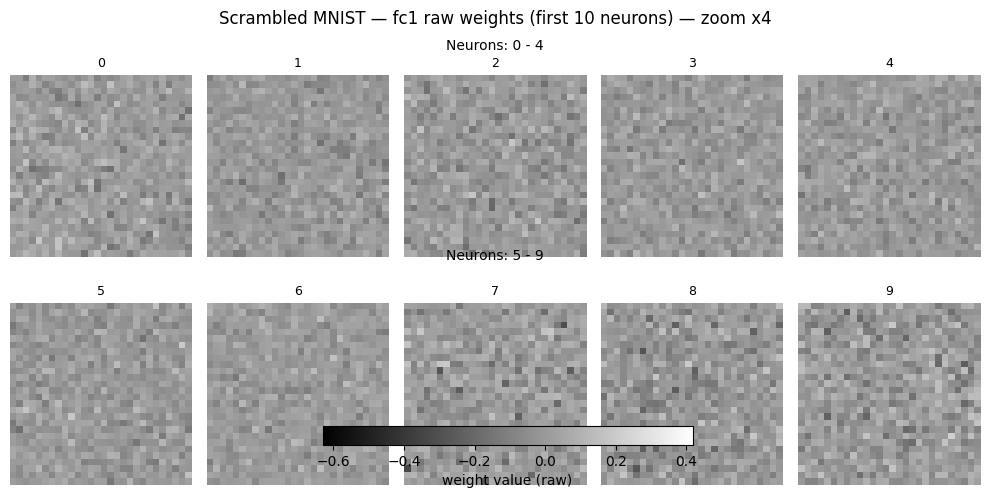

/tmp/ipykernel_55/4049159175.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


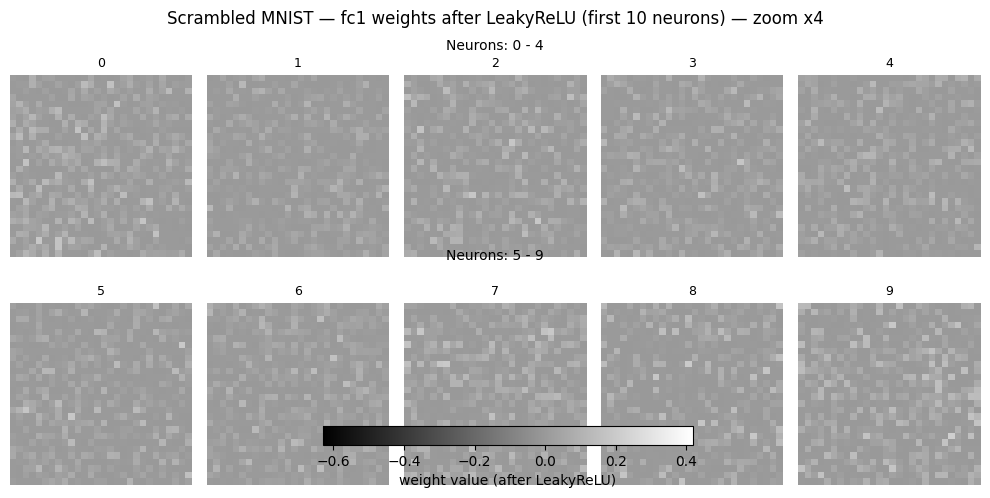

/tmp/ipykernel_55/4049159175.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


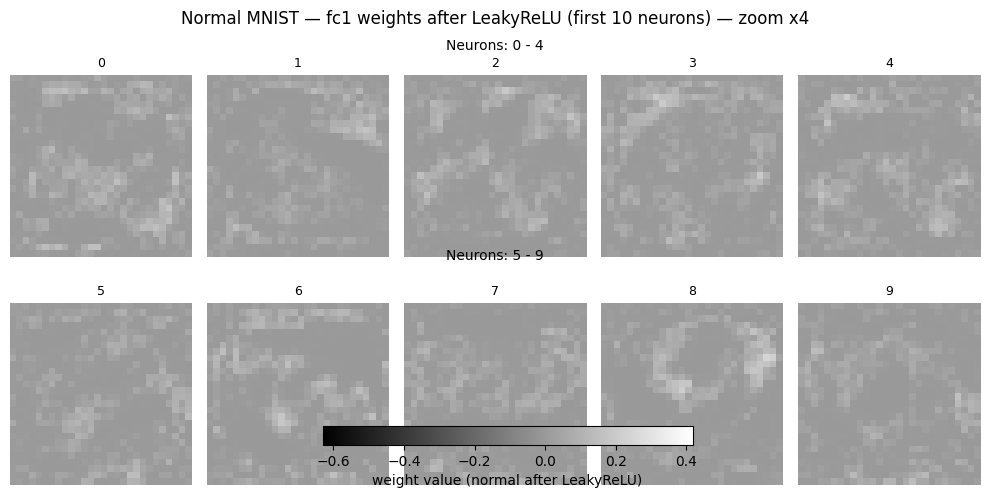

In [14]:
n_show = 10
zoom_factor = 4 
w_scr_t = model_scr.fc1.weight.data.cpu()   # tensor (hidden, 784)
w_norm_t = model.fc1.weight.data.cpu()
w_scr_relu_t = F.leaky_relu(w_scr_t, negative_slope=0.01)
w_norm_relu_t = F.leaky_relu(w_norm_t, negative_slope=0.01)

# Converting it to numpy for plotting
w_scr = w_scr_t.numpy()
w_scr_relu = w_scr_relu_t.numpy()
w_norm_relu = w_norm_relu_t.numpy()
vmin = float(min(w_scr.min(), w_scr_relu.min(), w_norm_relu.min()))
vmax = float(max(w_scr.max(), w_scr_relu.max(), w_norm_relu.max()))

def zoom_img(arr, factor):
    if factor == 1:
        return arr
    return np.kron(arr, np.ones((factor, factor)))

# 1) Scrambled raw weights — 2x5 layout
fig1, axes1 = plt.subplots(2, 5, figsize=(10,5), dpi=100)
fig1.suptitle('Scrambled MNIST — fc1 raw weights (first {} neurons) — zoom x{}'.format(n_show, zoom_factor))
plt.subplots_adjust(top=0.85)
fig1.text(0.5, 0.90, 'Neurons: 0 - 4', ha='center', fontsize=10)
fig1.text(0.5, 0.48, 'Neurons: 5 - 9', ha='center', fontsize=10)
for i in range(n_show):
    r = i // 5
    c = i % 5
    ax = axes1[r, c]
    img = w_scr[i].reshape(28,28)
    imgz = zoom_img(img, zoom_factor)
    im = ax.imshow(imgz, cmap='gray', vmin=vmin, vmax=vmax, interpolation='nearest')
    ax.set_title(f'{i}', fontsize=9)
    ax.axis('off')
cbar1 = fig1.colorbar(im, ax=axes1.ravel().tolist(), orientation='horizontal', fraction=0.05, pad=0.05)
cbar1.set_label('weight value (raw)')
plt.tight_layout()
plt.show()

# 2) Scrambled after LeakyReLU (zoomed) — 2x5 layout
fig2, axes2 = plt.subplots(2, 5, figsize=(10,5), dpi=100)
fig2.suptitle('Scrambled MNIST — fc1 weights after LeakyReLU (first {} neurons) — zoom x{}'.format(n_show, zoom_factor))
plt.subplots_adjust(top=0.85)
fig2.text(0.5, 0.90, 'Neurons: 0 - 4', ha='center', fontsize=10)
fig2.text(0.5, 0.48, 'Neurons: 5 - 9', ha='center', fontsize=10)
for i in range(n_show):
    r = i // 5
    c = i % 5
    ax = axes2[r, c]
    img = w_scr_relu[i].reshape(28,28)
    imgz = zoom_img(img, zoom_factor)
    im2 = ax.imshow(imgz, cmap='gray', vmin=vmin, vmax=vmax, interpolation='nearest')
    ax.set_title(f'{i}', fontsize=9)
    ax.axis('off')
cbar2 = fig2.colorbar(im2, ax=axes2.ravel().tolist(), orientation='horizontal', fraction=0.05, pad=0.05)
cbar2.set_label('weight value (after LeakyReLU)')
plt.tight_layout()
plt.show()

# 3) Normal model after LeakyReLU (zoomed) — 2x5 layout
fig3, axes3 = plt.subplots(2, 5, figsize=(10,5), dpi=100)
fig3.suptitle('Normal MNIST — fc1 weights after LeakyReLU (first {} neurons) — zoom x{}'.format(n_show, zoom_factor))
plt.subplots_adjust(top=0.85)
fig3.text(0.5, 0.90, 'Neurons: 0 - 4', ha='center', fontsize=10)
fig3.text(0.5, 0.48, 'Neurons: 5 - 9', ha='center', fontsize=10)
for i in range(n_show):
    r = i // 5
    c = i % 5
    ax = axes3[r, c]
    img = w_norm_relu[i].reshape(28,28)
    imgz = zoom_img(img, zoom_factor)
    im3 = ax.imshow(imgz, cmap='gray', vmin=vmin, vmax=vmax, interpolation='nearest')
    ax.set_title(f'{i}', fontsize=9)
    ax.axis('off')
cbar3 = fig3.colorbar(im3, ax=axes3.ravel().tolist(), orientation='horizontal', fraction=0.05, pad=0.05)
cbar3.set_label('weight value (normal after LeakyReLU)')
plt.tight_layout()
plt.show()

## Loss vs Epoch Graph

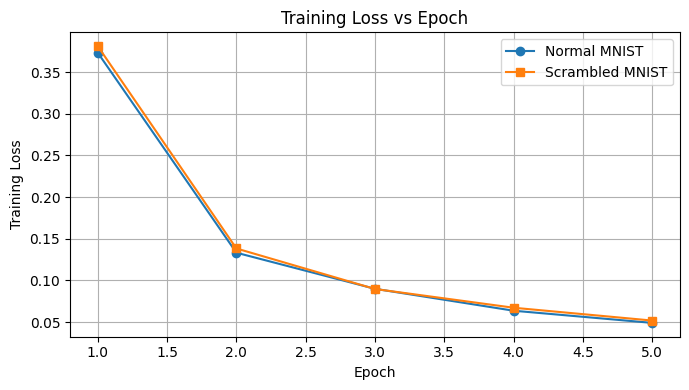

In [15]:
plt.figure(figsize=(7,4))
plt.plot(range(1, epochs+1), losses_normal, marker='o', label='Normal MNIST')
plt.plot(range(1, epochs+1), losses_scrambled, marker='s', label='Scrambled MNIST')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()